# 0.Constants

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_IDX=0
BERT_CLS_IDX=101
BERT_SEP_IDX=102

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 1.Importing Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 15.4MB/s 
     |████████████████████████████████| 890kB 26.6MB/s 
     |████████████████████████████████| 3.0MB 33.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4350087828b4a60a6ab8aee8d12697eb743288aeff7751f2c9fe30ae0a608f94
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import csv
import shutil
import numpy as np
import copy
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from itertools import chain
from collections import Counter
import json
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import vgg19
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from transformers import BertModel,BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2.Preparing Dataset

In [ ]:
 !unzip drive/My\ Drive/Colab\ Data/mscoco.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./mscoco/COCO_train2014_000000486641.jpg  
  inflating: ./mscoco/COCO_train2014_000000486713.jpg  
  inflating: ./mscoco/COCO_train2014_000000486717.jpg  
  inflating: ./mscoco/COCO_train2014_000000486718.jpg  
  inflating: ./mscoco/COCO_train2014_000000486732.jpg  
  inflating: ./mscoco/COCO_train2014_000000486793.jpg  
  inflating: ./mscoco/COCO_train2014_000000486807.jpg  
  inflating: ./mscoco/COCO_train2014_000000486821.jpg  
  inflating: ./mscoco/COCO_train2014_000000486854.jpg  
  inflating: ./mscoco/COCO_train2014_000000486869.jpg  
  inflating: ./mscoco/COCO_train2014_000000486870.jpg  
  inflating: ./mscoco/COCO_train2014_000000486906.jpg  
  inflating: ./mscoco/COCO_train2014_000000486936.jpg  
  inflating: ./mscoco/COCO_train2014_000000486960.jpg  
  inflating: ./mscoco/COCO_train2014_000000486972.jpg  
  inflating: ./mscoco/COCO_train2014_000000486977.jpg  
  inflating: ./mscoco/COCO_train2014_000000486983.jpg

## 2.0.Vocabulary



In [ ]:
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
BERT_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True).to(DEVICE)
BERT_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## 2.1.Batch Preparation Collate

In [ ]:
# # Taken from HW4 Part3
# def pad_tensor(tensor: torch.Tensor, size: int, dim: int=-1):
#   """
#   tensor: tensor to pad
#   size: the size to pad to
#   dim: dimension to pad
#   returns a new tensor padded to 'size' in dimension 'dim'
#   """
#   pad_size = list(tensor.shape)
#   pad_size[dim] = size - tensor.size(dim)
#   pad = torch.full(pad_size, PAD_IDX, dtype=tensor.dtype, device=tensor.device)
#   return torch.cat([tensor, pad], dim=dim)

# Thanks to https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8
class BatchPrepareCollate:
  def __init__(self,vgg,fcnn,mode='train',task='reg2cap'):
    self.vgg=vgg
    self.fcnn=fcnn
    self.mode=mode
    self.task=task
    self.vgg_transforms=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  def BatchPrepare_collate(self, batch,mode,task):

    if not task=='reg2cap':
      batch_image=[transforms.functional.to_tensor(s['image']).to(DEVICE) for s in batch]
      with torch.no_grad():
        fcnn_res=self.fcnn(batch_image)
      
      batch_image_boxes=[]
      for i in range(len(fcnn_res)):
        boxes,scores=fcnn_res[i]['boxes'].detach(),fcnn_res[i]['scores'].detach()
        most_likely_boxes=boxes[scores>=(0.75 if mode=='train' else 0.7)]
        if most_likely_boxes.size(0)>1:
          if mode!='test':
            box_distances_to_true_box=torch.norm(most_likely_boxes-batch[i]['true_box'][:4],dim=1)
            nearest_box_idx=torch.argmin(box_distances_to_true_box).item()
            other_boxes=most_likely_boxes[[idx for idx in range(most_likely_boxes.shape[0]) if idx!=nearest_box_idx],:]
          else:
            other_boxes=most_likely_boxes
          if mode=='train':
            false_box=other_boxes[torch.randint(other_boxes.size(0),(1,)).item()]
            false_box_s=torch.tensor([(false_box[2]-false_box[0])*(false_box[3]-false_box[1])],device=DEVICE)  
            batch_image_boxes+=[torch.cat((false_box,false_box_s))]
          else:
            batch_image_boxes+=[torch.cat((other_boxes,((other_boxes[:,2]-other_boxes[:,0])*(other_boxes[:,3]-other_boxes[:,1])).unsqueeze(dim=1)),dim=1)]
        elif most_likely_boxes.size(0)==0 or mode!='test':
          dummy_box=torch.zeros((4,),device=DEVICE)
          dummy_box_s=torch.zeros((1,),device=DEVICE)
          if mode=='train':
            batch_image_boxes+=[torch.cat((dummy_box,dummy_box_s))]
          else:
            batch_image_boxes+=[torch.cat((dummy_box,dummy_box_s)).unsqueeze(dim=0)]
        else:
          batch_image_boxes+=[torch.cat((most_likely_boxes,((most_likely_boxes[:,2]-most_likely_boxes[:,0])*(most_likely_boxes[:,3]-most_likely_boxes[:,1])).unsqueeze(dim=1)),dim=1)]
      torch.cuda.empty_cache()
    
    batch_image_features=torch.stack([s['VGGimageFeatures'] for s in batch]).to(DEVICE)

    if not (mode=='test' and task=='cap2reg'):
      batch_region_features=torch.stack([s['VGGregionFeatures'] for s in batch]).to(DEVICE)
      batch_region_features=self.vgg['last'](batch_region_features)

    if mode=='train' or task=='reg2cap':
      true_spatial_features=torch.stack([s['true_box']/s['spatial_features_denominator'] for s in batch])
      batch_true_box_features=torch.cat((batch_region_features,true_spatial_features),dim=1)

      batch_init_attn_masks=torch.stack([s['initAttnMask'] for s in batch])
      batch_init_attn_vecs=(batch_image_features @ batch_init_attn_masks.unsqueeze(dim=2)).squeeze(dim=2)

    if mode=='train' and task=='cap2reg':
      regions_vggInputs=[]
      for i in range(len(batch)):
        x_tl,y_tl,x_br,y_br=batch_image_boxes[i][:4].cpu().numpy()
        h,w=y_br-y_tl,x_br-x_tl
        regions_vggInputs+=[self.vgg_transforms(transforms.functional.crop(batch[i]['image'],y_tl,x_tl,h,w)).to(DEVICE)]      
      for i in range(len(batch)):
        batch_image_boxes[i]=batch_image_boxes[i]/batch[i]['spatial_features_denominator']
      batch_false_box_spatial_features=torch.stack(batch_image_boxes)
      with torch.no_grad():
        region_features=self.vgg['cls'](self.vgg['feat'](torch.stack(regions_vggInputs)))
      region_features=self.vgg['last'](region_features)
      batch_false_box_features=torch.cat((region_features,batch_false_box_spatial_features),dim=1)
    elif mode!='train' and task=='cap2reg':
      batch_image_regions_features=[]
      for i in range(len(batch)):
        regions_vggInputs=[]
        for j in range(batch_image_boxes[i].size(0)):
          x_tl,y_tl,x_br,y_br=batch_image_boxes[i][j][:4].cpu().numpy()
          h,w=y_br-y_tl,x_br-x_tl
          regions_vggInputs+=[self.vgg_transforms(transforms.functional.crop(batch[i]['image'],y_tl,x_tl,h,w)).to(DEVICE)]
        with torch.no_grad():
          region_features=self.vgg['last'](self.vgg['cls'](self.vgg['feat'](torch.stack(regions_vggInputs))))
        batch_image_regions_features+=[torch.cat([region_features,batch_image_boxes[i]/batch[i]['spatial_features_denominator']],dim=1)]

    if not (mode=='test' and task=='reg2cap'):
      sentences=BERT_tokenizer.batch_encode_plus([sample['sentence'] for sample in batch],
                                       add_special_tokens=True,max_length=10,truncation=True,
                                       padding=True,return_tensors='pt',return_length=True)
      with torch.no_grad():
        _,_,embed_hiddens=BERT_model(input_ids=sentences['input_ids'].to(DEVICE),attention_mask=sentences['attention_mask'].to(DEVICE),token_type_ids=sentences['token_type_ids'].to(DEVICE))
      embeddings=embed_hiddens[-2]
      if mode=='valid' and task=='reg2cap':
        padding_mask=(sentences['attention_mask']!=1).to(DEVICE)
      if mode!='train' and task=='cap2reg':
        sentence_lengths=sentences['length']
      sentences=sentences['input_ids'].to(DEVICE)

    if mode=='train' and task=='cap2reg':
      return sentences,embeddings,batch_image_features,batch_true_box_features,batch_false_box_features
    elif mode=='train' and task=='reg2cap':
      return sentences,embeddings,batch_image_features,batch_init_attn_vecs,batch_true_box_features
    elif mode=='valid' and task=='reg2cap':
      return sentences,embeddings,padding_mask,batch_image_features,batch_init_attn_vecs,batch_true_box_features
    elif mode=='test' and task=='reg2cap':
      return batch_image_features,batch_init_attn_vecs,batch_true_box_features
    else:
      return sentences,embeddings,sentence_lengths,batch_image_features,batch_image_regions_features,batch_image_boxes
  def __call__(self, batch):
    return self.BatchPrepare_collate(batch,self.mode,self.task)

## 2.2.Dataset Class

In [ ]:
class CapRegDataset(Dataset):
  def __init__(self,vgg,mode='train',task='reg2cap',csv_dir='/content/drive/My Drive/Colab Data/',coco_images_dir='mscoco/'):
    self.coco_images_dir=coco_images_dir
    self.csv_dir=csv_dir
    self.samples=[]
    self.images_features={}
    self.mode=mode
    self.task=task
    self.vgg_transforms=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  def build(self):
    fname='dataset.'+self.mode+'.csv'
    if self.mode=='test':
      if self.task=='reg2cap':
        fname='dataset.test.gen.csv'
      else:
        fname='dataset.test.comp.csv'
    with open(self.csv_dir+fname) as csvfile:
      reader=csv.reader(csvfile)
      key_names=next(reader)
      bstart=0
      length=0
      images=[]
      images_fnames=[]
      regions=[]
      for row in reader:
        sample=dict(zip(key_names,row))
        image=Image.open(self.coco_images_dir+sample['image_fname']).convert('RGB')
        if not (self.mode=='test' and self.task=='cap2reg'):
          sample['box']=[float(x) for x in sample['box'].replace('[','').replace(']','').split()]
          x_tl,y_tl,w,h=sample['box']
          regions+=[self.vgg_transforms(transforms.functional.crop(image,y_tl,x_tl,h,w))]
        if not (sample['image_fname'] in self.images_features):
          images+=[self.vgg_transforms(image)]
          images_fnames+=[sample['image_fname']]
          self.images_features[sample['image_fname']]=image
        length+=1
        self.samples+=[sample]
        if length==256:
          im_batch=torch.stack(images).to(DEVICE)
          with torch.no_grad():
            VGGimageFeatures=torch.unbind(vgg['feat'](im_batch).reshape(im_batch.size(0),512,49).detach().cpu())
          for i in range(len(VGGimageFeatures)):
            self.images_features[images_fnames[i]]=VGGimageFeatures[i]
          if not (self.mode=='test' and self.task=='cap2reg'):
            reg_batch=torch.stack(regions).to(DEVICE)
            with torch.no_grad():
              VGGregionFeatures=torch.unbind(vgg['cls'](vgg['feat'](reg_batch)).detach().cpu())
            for i in range(bstart,bstart+length):
                self.samples[i]['VGGregionFeatures']=VGGregionFeatures[i-bstart]
          print('preparing {} samples finished!'.format(len(self.samples)))
          bstart+=length
          length=0
          images=[]
          regions=[]
          images_fnames=[]
      if length!=0:
        im_batch=torch.stack(images).to(DEVICE)
        with torch.no_grad():
          VGGimageFeatures=torch.unbind(vgg['feat'](im_batch).reshape(im_batch.size(0),512,49).detach().cpu())
        for i in range(len(VGGimageFeatures)):
            self.images_features[images_fnames[i]]=VGGimageFeatures[i]
        if not (self.mode=='test' and self.task=='cap2reg'):
          reg_batch=torch.stack(regions).to(DEVICE)
          with torch.no_grad():
            VGGregionFeatures=torch.unbind(vgg['cls'](vgg['feat'](reg_batch)).detach().cpu())
          for i in range(bstart,bstart+length):
              self.samples[i]['VGGregionFeatures']=VGGregionFeatures[i-bstart]
        print('preparing {} samples finished!'.format(len(self.samples)))
        bstart+=length
        length=0
        images=[]
        regions=[]
        images_fnames=[]
      print('Reading Dataset file finished!')
  def __len__(self):
    return len(self.samples)
  def __getitem__(self, idx):
    sample=self.samples[idx]
    image=Image.open(self.coco_images_dir+sample['image_fname']).convert('RGB')
    W,H=image.size
    if not (self.mode=='test' and self.task=='cap2reg'):
      x_tl,y_tl,w,h=sample['box']
      initAttnLeftCol,initAttnRightCol=int(np.ceil((x_tl/W)*7)-1),int(np.ceil(((x_tl+w)/W)*7)-1)
      initAttnTopRow,initAttnBottomRow=int(np.ceil((y_tl/H)*7)-1),int(np.ceil(((y_tl+h)/H)*7-1))
      if initAttnLeftCol==-1:
        initAttnLeftCol+=1
      if initAttnRightCol==-1:
        initAttnRightCol+=1
      if initAttnTopRow==-1:
        initAttnTopRow+=1
      if initAttnBottomRow==-1:
        initAttnBottomRow+=1
      initAttnMask=torch.zeros((7,7),dtype=torch.float,device=DEVICE)
      for c in range(initAttnLeftCol,initAttnRightCol+1):
        for r in range(initAttnTopRow,initAttnBottomRow+1):
          initAttnMask[r,c]=1./((initAttnRightCol+1-initAttnLeftCol)*(initAttnBottomRow+1-initAttnTopRow))
      s_region=h*w
    denominator=torch.tensor([W,H,W,H,W*H],dtype=torch.float,device=DEVICE)

    if (self.mode=='test' and self.task=='cap2reg'):
      return {'sentence':sample['sentence'],
            'spatial_features_denominator':denominator,
            'image':image,
            'VGGimageFeatures':self.images_features[sample['image_fname']]}
    elif (self.mode=='test' and self.task=='reg2cap'):
      return {'true_box':torch.tensor([x_tl,y_tl,x_tl+w,y_tl+h,s_region],device=DEVICE),
            'spatial_features_denominator':denominator,
            'image':image,
            'initAttnMask':initAttnMask.reshape((49,)),
            'VGGimageFeatures':self.images_features[sample['image_fname']],
            'VGGregionFeatures':sample['VGGregionFeatures']
            }  
    return {'sentence':sample['sentence'],
            'true_box':torch.tensor([x_tl,y_tl,x_tl+w,y_tl+h,s_region],device=DEVICE),
            # 'true_box_size':(y_br-y_tl,x_br-x_tl),
            'spatial_features_denominator':denominator,
            'image':image,
            'initAttnMask':initAttnMask.reshape((49,)),
            'VGGimageFeatures':self.images_features[sample['image_fname']],
            'VGGregionFeatures':sample['VGGregionFeatures']
            }

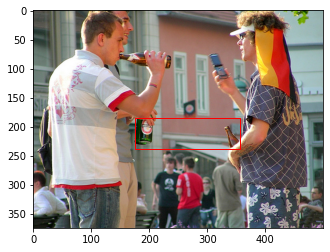

In [ ]:
import matplotlib.patches as patches

image=Image.open('mscoco/'+trainDS.samples[5]['image_fname']).convert('RGB')
x_tl,y_tl,w,h=trainDS.samples[5]['box']
fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((x_tl,y_tl),w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# 3.Defining Model

In [ ]:
class CapRegModel(nn.Module):
  def __init__(self,task='reg2cap'):
    super(CapRegModel, self).__init__()
    self.task=task
    self.vocab_size=BERT_tokenizer.vocab_size
    self.hidden_size=1024
    self.embed_size=768
    self.region_feat_size=1005
    self.attention_size=512
    self.teacher_forcing_rate=0.7
    self.lstm=nn.LSTMCell(self.attention_size+self.region_feat_size+self.embed_size,self.hidden_size)
    self.lstm2=nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.lstm_to_attn_weights=nn.Linear(self.hidden_size,49,bias=False)
    self.after_lstm_dropout=nn.Dropout(p=0.5)
    self.lstm_to_vocab=nn.Linear(self.hidden_size,self.vocab_size,bias=False)
  def change_task(self,task):
    self.task=task
  def forward(self,args):
    if self.training and self.task=='cap2reg':
      sentences,embeddings,batch_image_features,batch_true_box_features,batch_false_box_features=args
      combined_batch_input12=[]
      combined_batch_images=[]
      sentences_combined=[]
      for i in range(batch_true_box_features.size(0)*2):
        idx=i//2 if (i%2==0) else (i-1)//2
        row=batch_true_box_features[idx] if (i%2==0) else batch_false_box_features[idx]
        input1=row.unsqueeze(dim=0).expand((sentences.size(1)-1,self.region_feat_size))
        input2=embeddings[idx,:-1]
        combined_batch_input12+=[torch.cat([input1,input2],dim=1)]
        combined_batch_images+=[batch_image_features[idx]]
        sentences_combined+=[sentences[idx,1:]]
      combined_batch_images=torch.stack(combined_batch_images)
      lstm_input12=torch.stack(combined_batch_input12)#shape after: (2*B,T,F1+F2)
      lstm_input3=torch.zeros((batch_true_box_features.size(0)*2,self.attention_size),dtype=torch.float,device=DEVICE)
      h,c=torch.zeros((batch_true_box_features.size(0)*2,self.hidden_size),dtype=torch.float,device=DEVICE),torch.zeros((batch_true_box_features.size(0)*2,self.hidden_size),dtype=torch.float,device=DEVICE)
      all_logits=[]
      for t in range(sentences.size(1)-1):
        lstm_input=torch.cat([lstm_input12[:,t,:],lstm_input3],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.after_lstm_dropout(h)
        all_logits+=[self.lstm_to_vocab(h_dropout)]
        lstm_input3=(combined_batch_images @ F.softmax(self.lstm_to_attn_weights(h_dropout),dim=1).unsqueeze(dim=2)).squeeze(dim=2)#out shape:(B,attn_size)
      logits=torch.stack(all_logits,dim=2)#shape after: (B,F,T).to be able to feed into CrossEntropy
      loss=F.cross_entropy(logits,torch.stack(sentences_combined),reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      return torch.mean(torch.sum(loss[[2*i for i in range(batch_true_box_features.size(0))]],dim=1))-torch.mean(torch.sum(loss[[2*i+1 for i in range(batch_false_box_features.size(0))]],dim=1))
    elif self.training and self.task=='reg2cap':
      sentences,embeddings,batch_image_features,batch_init_attn_vecs,batch_true_box_features=args
      h,c=[torch.zeros((batch_true_box_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      h2,c2=[torch.zeros((batch_true_box_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_logits=[]
      for t in range(sentences.size(1)-1):
        if t==0:
          lstm_input2=embeddings[:,t]
          lstm_input3=batch_init_attn_vecs
        else:
          lstm_input3=(batch_image_features @ F.softmax(self.lstm_to_attn_weights(h_dropout),dim=1).unsqueeze(dim=2)).squeeze(dim=2)#out shape:(B,attn_size)
          if np.random.uniform()<=0.7:
            lstm_input2=embeddings[:,t]
          else:
            with torch.no_grad():
              input2=torch.multinomial(F.softmax(logits,dim=1),1)
              lstm_input2=BERT_model(torch.cat((sentences[:,:t],input2),dim=1))[2][-2][:,-1]
        lstm_input=torch.cat([batch_true_box_features,lstm_input2,lstm_input3],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h2,c2=self.lstm2(h,(h2,c2))
        h_dropout=self.after_lstm_dropout(h2)
        logits=self.lstm_to_vocab(h_dropout)
        all_logits+=[logits]
      loss=F.cross_entropy(torch.stack(all_logits,dim=2),sentences[:,1:],reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      return torch.mean(torch.sum(loss,dim=1))      
    elif self.task=='reg2cap':
      sentences,embeddings,padding_mask,batch_image_features,batch_init_attn_vecs,batch_true_box_features=args
      preds=[]
      lstm_input2=embeddings[:,0]
      lstm_input3=batch_init_attn_vecs
      h,c=[torch.zeros((batch_true_box_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      h2,c2=[torch.zeros((batch_true_box_features.size(0),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_logits=[]
      for t in range(sentences.size(1)-1):
        lstm_input=torch.cat([batch_true_box_features,lstm_input2,lstm_input3],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h2,c2=self.lstm2(h,(h2,c2))
        h_dropout=self.after_lstm_dropout(h2)
        logits=self.lstm_to_vocab(h_dropout)
        pred=torch.multinomial(F.softmax(logits,dim=1),1)
        preds+=[pred.squeeze(dim=1)]
        all_logits+=[logits]
        lstm_input3=(batch_image_features @ F.softmax(self.lstm_to_attn_weights(h_dropout),dim=1).unsqueeze(dim=2)).squeeze(dim=2)#out shape:(B,attn_size)      
        with torch.no_grad():
          lstm_input2=BERT_model(torch.cat((torch.stack(preds,dim=1),pred),dim=1))[2][-2][:,-1]
      loss=F.cross_entropy(torch.stack(all_logits,dim=2),sentences[:,1:],reduction='none',ignore_index=PAD_IDX)#shape after: (B,T)
      preds_padding_restored=torch.stack(preds,dim=1).masked_fill_(padding_mask[:,1:],0)
      return torch.mean(torch.sum(loss,dim=1)),preds_padding_restored
    else:
      #batch_image_regions_features: List(len:batchSize)[Tensor(regionCnt(depends on image),region_feat_size)]
      sentences,embeddings,sentence_lengths,batch_image_features,batch_image_regions_features,batch_image_boxes=args
      batch_region_cnts=[s.size(0) for s in batch_image_regions_features]
      lstm_input1=torch.cat([s.unsqueeze(dim=1).expand((s.size(0),sentences.size(1)-1,self.region_feat_size)) for s in batch_image_regions_features],dim=0)
      lstm_input2=torch.cat([embeddings[i][:-1].unsqueeze(dim=0).expand((batch_image_regions_features[i].size(0),sentences.size(1)-1,self.embed_size)) for i in range(sentences.size(0))],dim=0)
      lstm_input12=torch.cat([lstm_input1,lstm_input2],dim=2)
      lstm_input3=torch.zeros((sum(batch_region_cnts),self.attention_size),dtype=torch.float,device=DEVICE)
      h,c=[torch.zeros((sum(batch_region_cnts),self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
      all_log_probs=[]
      batch_image_features_combined=[]
      for i in range(batch_image_features.size(0)):
        batch_image_features_combined+=[batch_image_features[i].expand((batch_region_cnts[i],self.attention_size,49))]
      batch_image_features_combined=torch.cat(batch_image_features_combined)
      for t in range(sentences.size(1)-1):
        lstm_input=torch.cat([lstm_input12[:,t,:],lstm_input3],dim=1)
        h,c=self.lstm(lstm_input,(h,c))
        h_dropout=self.after_lstm_dropout(h)
        logits=self.lstm_to_vocab(h_dropout)
        all_log_probs+=[F.log_softmax(logits,dim=1)]
        lstm_input3=(batch_image_features_combined @ F.softmax(self.lstm_to_attn_weights(h_dropout),dim=1).unsqueeze(dim=2)).squeeze(dim=2)#out shape:(B,attn_size)
      log_probs=torch.stack(all_log_probs,dim=1)
      regionNum=0
      best_regions=[]
      for i in range(len(batch_image_regions_features)):
        sample_log_probs=log_probs[regionNum:regionNum+batch_region_cnts[i]]
        sample_log_probs_unpadded=sample_log_probs[:,:sentence_lengths[i]-1]
        sample_regions_log_probs=torch.sum(sample_log_probs_unpadded[:,list(range(sentence_lengths[i]-1)),sentences[i,1:sentence_lengths[i]]],dim=1)
        best_regions+=[(batch_image_boxes[i][torch.argmax(sample_regions_log_probs,dim=0)],torch.exp(torch.max(sample_regions_log_probs,dim=0)[0]))]
        regionNum+=batch_region_cnts[i]
      return best_regions
  def generate_caption(self,args):
      batch_image_features,batch_init_attn_vecs,batch_true_box_features=args
      max_len_sentence=10
      predictions=[]
      for i in range(batch_true_box_features.size(0)):
        preds=[]
        input2=torch.tensor([[BERT_CLS_IDX]],device=DEVICE)
        with torch.no_grad():
          lstm_input2=BERT_model(input2)[2][-2][0,-1]
        lstm_input3=batch_init_attn_vecs[i]
        h,c=[torch.zeros((1,self.hidden_size),dtype=torch.float,device=DEVICE) for i in range(2)]
        for t in range(max_len_sentence-1):
          lstm_input=torch.cat([batch_true_box_features[i],lstm_input2,lstm_input3]).unsqueeze(dim=0)
          h,c=self.lstm(lstm_input,(h,c))
          h_dropout=self.after_lstm_dropout(h)
          logits=self.lstm_to_vocab(h_dropout)
          pred=torch.multinomial(F.softmax(logits[0],dim=0),1)
          preds+=[pred.item()]
          if pred.item()==BERT_SEP_IDX:
            break
          with torch.no_grad():
            lstm_input2=BERT_model(torch.tensor([[BERT_CLS_IDX]+preds],device=DEVICE))[2][-2][0,-1]
          lstm_input3=(batch_image_features[i] @ F.softmax(self.lstm_to_attn_weights(h_dropout),dim=1).unsqueeze(dim=2)).squeeze(dim=2).squeeze(dim=0)#out shape:(attn_size,)
        predictions+=[preds]
      return predictions

# 4.Training Procedure

## 4.0. Hyperparameters

In [ ]:
BATCH_SIZE=256
LR=0.001
EPOCHS=10

## 4.1. Instantiating Classes

In [ ]:
fcnn=fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
fcnn.eval()
vgg19_model = vgg19(pretrained=True)
vggLastLayer=copy.deepcopy(vgg19_model.classifier[6]).to(DEVICE)
del vgg19_model.classifier[6]
vggClassifier=copy.deepcopy(vgg19_model.classifier)
vggClassifier=nn.Sequential(nn.Flatten(1),vggClassifier).to(DEVICE)
del vgg19_model.classifier
vggFeatures=nn.Sequential(vgg19_model.features,vgg19_model.avgpool).to(DEVICE)
# for param in vggLastLayer.parameters():
#   param.requires_grad = False
for param in vggClassifier.parameters():
  param.requires_grad = False
for param in vggFeatures.parameters():
  param.requires_grad = False
# vggLastLayer.eval()
vggClassifier.eval()
vggFeatures.eval()
vgg={'feat':vggFeatures,'cls':vggClassifier,'last':vggLastLayer}

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
trainDS=CapRegDataset(vgg)
trainDS.build()
testDS=CapRegDataset(vgg,mode='valid')
testDS.build()

preparing 256 samples finished!
preparing 512 samples finished!
preparing 768 samples finished!
preparing 1024 samples finished!
preparing 1280 samples finished!
preparing 1536 samples finished!
preparing 1792 samples finished!
preparing 2048 samples finished!
preparing 2304 samples finished!
preparing 2560 samples finished!
preparing 2816 samples finished!
preparing 3072 samples finished!
preparing 3328 samples finished!
preparing 3584 samples finished!
preparing 3840 samples finished!
preparing 4096 samples finished!
preparing 4352 samples finished!
preparing 4608 samples finished!
preparing 4864 samples finished!
preparing 5120 samples finished!
preparing 5376 samples finished!
preparing 5632 samples finished!
preparing 5888 samples finished!
preparing 6144 samples finished!
preparing 6400 samples finished!
preparing 6656 samples finished!
preparing 6912 samples finished!
preparing 7168 samples finished!
preparing 7424 samples finished!
preparing 7680 samples finished!
preparing 793

In [ ]:
trainDL=DataLoader(trainDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn))
reg2capTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='valid'))
cap2regTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='valid',task='cap2reg'))

In [ ]:
model=CapRegModel().to(DEVICE)
# print(model.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_attention_epoch60_loss47.454.pt')))

In [ ]:
optimizer=torch.optim.Adam(list(model.parameters())+list(vgg['last'].parameters()),lr=LR)
# print(optimizer.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_attention_optim_epoch54_loss47.632.pt')))

## 4.2.Train Loop

In [ ]:
epochs_train_losses=[]
epochs_test_losses=[]
train_batch_cnt=len(trainDS)//BATCH_SIZE
test_batch_cnt=len(testDS)//BATCH_SIZE

In [ ]:
import json
f=open('drive/My Drive/Colab Data/attention_loss_history.json','r')
d=json.loads(f.read())
epochs_train_losses=d['train']
epochs_test_losses=d['test']

In [ ]:
model.train()
vgg['last'].train()
model.change_task('reg2cap')
for epoch in range(EPOCHS):
  batches_train_losses=[]
  for num,batch in enumerate(trainDL):
    model.zero_grad()
    loss=model(batch)
    loss.backward()
    optimizer.step()
    batches_train_losses+=[loss.item()]
    if num%10==0:
      avg_loss=np.mean(batches_train_losses)
      print('Train ,Epoch#{} ,batch {}/{} ,avg-loss: {}'.format(epoch+1,num+1,train_batch_cnt,avg_loss))
  epoch_loss=np.mean(batches_train_losses)
  print('Train ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
  if (epoch>0 and epoch_loss<min(epochs_train_losses)) or epoch+1==EPOCHS:
    torch.save(model.state_dict(),'DL_FP_attention_sgd_2lstm_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1))
    shutil.move('DL_FP_attention_sgd_2lstm_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1),'drive/My Drive/Colab Data')
    torch.save(optimizer.state_dict(),'DL_FP_attention_sgd_2lstm_optim_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1))
    shutil.move('DL_FP_attention_sgd_2lstm_optim_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1),'drive/My Drive/Colab Data')
    torch.save(vgg['last'].state_dict(),'DL_FP_attention_vgglast_sgd_2lstm_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1))
    shutil.move('DL_FP_attention_vgglast_sgd_2lstm_loss{:.1f}_epoch{}.pt'.format(epoch_loss,epoch+1),'drive/My Drive/Colab Data')
  epochs_train_losses+=[epoch_loss]
  #####Test
  model.eval()
  vgg['last'].eval()
  model.change_task('reg2cap')
  batches_test_losses=[]
  for num,batch in enumerate(reg2capTestDL):
    with torch.no_grad():
      loss,_=model(batch)
      batches_test_losses+=[loss.item()]
      if num%10==0:
        avg_loss=np.mean(batches_test_losses)
        print('Test ,batch {}/{} ,avg-loss: {}'.format(num+1,test_batch_cnt,avg_loss))
  model.train()
  vgg['last'].train()
  epoch_loss=np.mean(batches_test_losses)
  epochs_test_losses+=[epoch_loss]
  print('Test ,Epoch#{} ,loss:{}'.format(epoch+1,epoch_loss))
  f=open('drive/My Drive/Colab Data/attention_loss_history.json','w')
  s=json.dumps({'train':epochs_train_losses,'test':epochs_test_losses})
  f.write(s)
  f.close()

Train ,Epoch#1 ,batch 1/314 ,avg-loss: 85.10997772216797
Train ,Epoch#1 ,batch 11/314 ,avg-loss: 57.76718521118164
Train ,Epoch#1 ,batch 21/314 ,avg-loss: 51.372788747151695
Train ,Epoch#1 ,batch 31/314 ,avg-loss: 48.29702328097436
Train ,Epoch#1 ,batch 41/314 ,avg-loss: 46.48185069386552
Train ,Epoch#1 ,batch 51/314 ,avg-loss: 45.32000268674364
Train ,Epoch#1 ,batch 61/314 ,avg-loss: 44.46208910082208
Train ,Epoch#1 ,batch 71/314 ,avg-loss: 43.827746700233135
Train ,Epoch#1 ,batch 81/314 ,avg-loss: 43.325228844159916
Train ,Epoch#1 ,batch 91/314 ,avg-loss: 42.89920261928013
Train ,Epoch#1 ,batch 101/314 ,avg-loss: 42.51735785455987
Train ,Epoch#1 ,batch 111/314 ,avg-loss: 42.19097996617223
Train ,Epoch#1 ,batch 121/314 ,avg-loss: 41.919581894047006
Train ,Epoch#1 ,batch 131/314 ,avg-loss: 41.686500461956925
Train ,Epoch#1 ,batch 141/314 ,avg-loss: 41.490195849263074
Train ,Epoch#1 ,batch 151/314 ,avg-loss: 41.29896216992511
Train ,Epoch#1 ,batch 161/314 ,avg-loss: 41.1517036153663
Tra

In [ ]:
plt.plot(epochs_train_losses)
plt.plot(epochs_test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

# 5.Evaluation

In [ ]:
model=CapRegModel().to(DEVICE)
print(model.load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_attention_adam_1lstm_loss36.5_epoch9.pt')))
model.eval()
#
print(vgg['last'].load_state_dict(torch.load('drive/My Drive/Colab Data/DL_FP_attention_vgglast_adam_1lstm_loss36.5_epoch9.pt')))
vgg['last'].eval()

<All keys matched successfully>
<All keys matched successfully>


Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
testDS=CapRegDataset(vgg,mode='valid')
testDS.build()
BATCH_SIZE=256
test_batch_cnt=len(testDS)//BATCH_SIZE

preparing 256 samples finished!
preparing 512 samples finished!
preparing 768 samples finished!
preparing 1024 samples finished!
preparing 1280 samples finished!
preparing 1536 samples finished!
preparing 1792 samples finished!
preparing 2048 samples finished!
preparing 2304 samples finished!
preparing 2560 samples finished!
preparing 2816 samples finished!
preparing 3072 samples finished!
preparing 3328 samples finished!
preparing 3584 samples finished!
preparing 3840 samples finished!
preparing 4096 samples finished!
preparing 4352 samples finished!
preparing 4608 samples finished!
preparing 4864 samples finished!
preparing 4895 samples finished!
Reading Dataset file finished!


In [ ]:
reg2capTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test'))
cap2regTestDL=DataLoader(testDS,batch_size=8,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test',task='cap2reg'))

In [ ]:
model.eval()
vgg['last'].eval()
model.change_task('reg2cap')
cap_predictions=[]
for num,batch in enumerate(reg2capTestDL):
    with torch.no_grad():
      preds=model.generate_caption(batch)
    cap_predictions+=BERT_tokenizer.batch_decode(preds,skip_special_tokens=True)
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))

Test ,batch 1/19
Test ,batch 11/19


In [ ]:
print(cap_predictions[:10])

['overcome isuppe 1971 woman rebuild with 雄 chair', 'galicia with in back', 'the. kid holding next bus stabbed in a', '##hs in wii in the head sud long yellow', '##uating on brown to alexa chair to a.', 'suffrage black wearing pink the a out apply a', 'a', 'of ホ rotterdams girl his in as', 'the', 'the blend']


In [ ]:
import pandas as pd
tgt_frame=pd.read_csv('drive/My Drive/Colab Data/dataset.valid.csv')
from bleu_score import eval_bleu
print(eval_bleu(tgt_frame,cap_predictions,1))

0.10180544541447126


In [ ]:
test_batch_cnt=len(testDS)//8
model.eval()
model.change_task('cap2reg')
box_predictions=[]
for num,batch in enumerate(cap2regTestDL):
    with torch.no_grad():
      preds=model(batch)
    box_predictions+=[tuple(pred[0][:4].cpu().numpy()) for pred in preds]
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Test ,batch 1/611
Test ,batch 11/611
Test ,batch 21/611
Test ,batch 31/611
Test ,batch 41/611
Test ,batch 51/611
Test ,batch 61/611
Test ,batch 71/611
Test ,batch 81/611
Test ,batch 91/611
Test ,batch 101/611
Test ,batch 111/611
Test ,batch 121/611
Test ,batch 131/611
Test ,batch 141/611
Test ,batch 151/611
Test ,batch 161/611
Test ,batch 171/611
Test ,batch 181/611
Test ,batch 191/611
Test ,batch 201/611
Test ,batch 211/611
Test ,batch 221/611
Test ,batch 231/611
Test ,batch 241/611
Test ,batch 251/611
Test ,batch 261/611
Test ,batch 271/611
Test ,batch 281/611
Test ,batch 291/611
Test ,batch 301/611
Test ,batch 311/611
Test ,batch 321/611
Test ,batch 331/611
Test ,batch 341/611
Test ,batch 351/611
Test ,batch 361/611
Test ,batch 371/611
Test ,batch 381/611
Test ,batch 391/611
Test ,batch 401/611
Test ,batch 411/611
Test ,batch 421/611
Test ,batch 431/611
Test ,batch 441/611
Test ,batch 451/611
Test ,batch 461/611
Test ,batch 471/611
Test ,batch 481/611
Test ,batch 491/611
Test ,batch

In [ ]:
from comprehension_score import eval_precision
print(eval_precision(tgt_frame,box_predictions))

(0.06557711950970378, 0.16091123371341676)


# 6.Test

In [ ]:
testDS=CapRegDataset(vgg,mode='test',task='reg2cap',vocab=vocab,csv_dir='')
reg2capTestDL=DataLoader(testDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test'))

In [ ]:
test_batch_cnt=len(testDS)//BATCH_SIZE
model.eval()
vgg['last'].eval()
model.change_task('reg2cap')
cap_predictions=[]
for num,batch in enumerate(reg2capTestDL):
    with torch.no_grad():
      preds=model.generate_caption(batch)
    for i in range(len(preds)):
      preds[i]=' '.join([vocab.get_token_by_id(id) for id in preds[i]])
    cap_predictions+=preds
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))
f=open('drive/My Drive/Colab Data/sentences.txt','w')
for sentence in cap_predictions:
  f.write(sentence+'\n')
f.close()

Test ,batch 1/37
Test ,batch 11/37
Test ,batch 21/37
Test ,batch 31/37


In [ ]:
testDS=CapRegDataset(vgg,mode='test',task='cap2reg',vocab=vocab,csv_dir='')
cap2regTestDL=DataLoader(testDS,batch_size=8,shuffle=True,num_workers=0,collate_fn=BatchPrepareCollate(vgg,fcnn,mode='test',task='cap2reg'))

In [ ]:
test_batch_cnt=len(testDS)//8
model.eval()
vgg['last'].eval()
model.change_task('cap2reg')
box_predictions=[]
for num,batch in enumerate(cap2regTestDL):
    with torch.no_grad():
      preds=model(batch)
    box_predictions+=[tuple(pred[0][:4].cpu().numpy()) for pred in preds]
    if num%10==0:
      print('Test ,batch {}/{}'.format(num+1,test_batch_cnt))
f=open('drive/My Drive/Colab Data/boxes.txt','w')
for box in box_predictions:
  f.write('{}, {}, {}, {}\n'.format(*box))
f.close()